# ECG Data Analysis

ECG values for waves and intervals in seconds & milliseconds: https://emedicine.medscape.com/article/2172196-overview?form=fpf

- RR interval: 0.6-1.2 seconds
- P wave: 80 milliseconds
- PR interval: 120-200 milliseconds
- PR segment: 50-120 milliseconds
- QRS complex: 80-100 milliseconds
- ST segment: 80-120 milliseconds
- T wave: 160 milliseconds
- QT interval: 420 milliseconds or less if heart rate is 60 beats per minute (bpm)

In [1]:
import wfdb # For reading in the data from the Physionet dataset
import numpy as np
import neurokit2 as nk # Library for cleaning ECG signal and performing automated pre-processing
import matplotlib.pyplot as plt
from scipy.signal import buttord ,butter, filtfilt # Using butterworth filter as example

%matplotlib inline

(1024, 3)


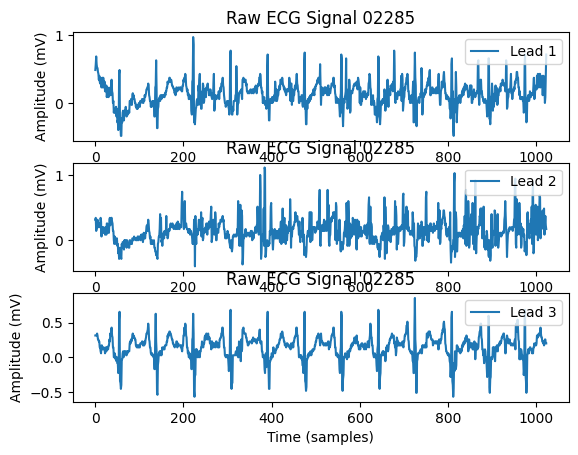

KeyboardInterrupt: 

In [7]:
import os

dataset_folder = 'dataset'
file_names = []
records = []

for file in os.listdir(dataset_folder):
    if file.endswith('.dat'):
        file_names.append(file.split('.')[0])

for file in file_names:
    record = wfdb.rdrecord(f'dataset/{file}',sampfrom=20000, sampto=20000+(128*8))  # Taking One minute/60 seconds of signal
    annotation = wfdb.rdann(f'dataset/{file}', 'qrs') # Annotation file that holds info on Q,R,S,T etc peaks

    records.append(record)

    ecg_signal = record.p_signal[:]  
    fs = record.fs # Sampling frequency from ECG signal
    print(ecg_signal.shape)

    for lead_idx in range(ecg_signal.shape[1]):
        plt.subplot(ecg_signal.shape[1], 1, lead_idx + 1)
        plt.plot(ecg_signal[:, lead_idx], label=f'Lead {lead_idx+1}')
        plt.title(f'Fake ECG - Lead {lead_idx+1}')
        plt.legend(loc='upper right')
        plt.xlabel("Time (samples)")
        plt.title(f"Raw ECG Signal {file}")
        plt.ylabel("Amplitude (mV)")
    plt.show()

## Filter ECG Signal

Using a bandpass signal to remove both low frequency noise and muscle tremor noise situated around the 50Hz mark

70
15


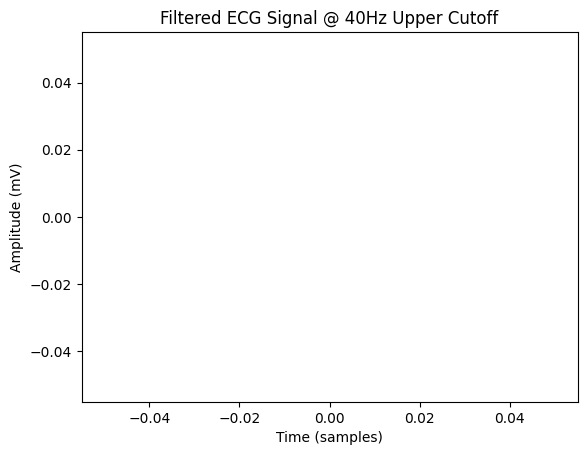

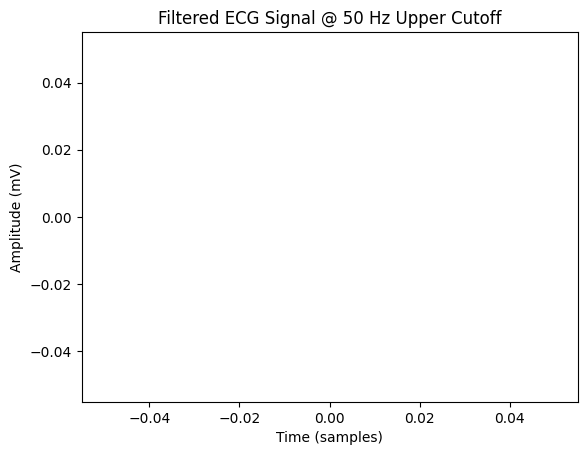

In [3]:
def bandpass_filter(signal, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    wp = [lowcut / nyquist, highcut / nyquist]
    ws = [(lowcut - 0.1) / nyquist, (highcut + 0.1) / nyquist]
    gpass = 0.5  # Passband ripple
    gstop = 1  # Stopband attenuation
    order, wn = buttord(wp, ws, gpass, gstop)
    print(order)
    b, a = butter(order, wn, btype="band")
    return filtfilt(b, a, signal)

filtered_ecg_40 = bandpass_filter(ecg_signal, 0.5, 40, fs)
filtered_ecg = bandpass_filter(ecg_signal, 0.5, 60, fs)

plt.plot(filtered_ecg_40[:fs * 1])
plt.title("Filtered ECG Signal @ 40Hz Upper Cutoff")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.show()

plt.plot(filtered_ecg[:fs * 1])
plt.title("Filtered ECG Signal @ 50 Hz Upper Cutoff")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.show()

In [4]:
ecg_cleaned = nk.ecg_clean(filtered_ecg, sampling_rate=fs)

signals, info = nk.ecg_process(ecg_cleaned, sampling_rate=fs)
r_peaks = np.array(info['ECG_R_Peaks'])
q_peaks = np.array(info['ECG_Q_Peaks'])
s_peaks = np.array(info['ECG_S_Peaks'])
t_peaks = np.array(info['ECG_T_Peaks'])

plt.plot(ecg_cleaned[:128])
plt.scatter(r_peaks[np.where(r_peaks < 128)[0]].astype(int), ecg_cleaned[r_peaks[np.where(r_peaks < 128)[0]].astype(int)], color='red', label="R-peaks")
plt.scatter(q_peaks[np.where(q_peaks < 128)[0]].astype(int), ecg_cleaned[q_peaks[np.where(q_peaks < 128)[0]].astype(int)], color='blue', label="Q-peaks")
plt.scatter(s_peaks[np.where(s_peaks < 128)[0]].astype(int), ecg_cleaned[s_peaks[np.where(s_peaks < 128)[0]].astype(int)], color='green', label="S-peaks")
plt.scatter(t_peaks[np.where(t_peaks < 128)[0]].astype(int), ecg_cleaned[t_peaks[np.where(t_peaks < 128)[0]].astype(int)], color='purple', label="T-peaks")
plt.title("ECG Signal with Detected Peaks")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

/home/elukbog/.local/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7680 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/home/elukbog/.local/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


KeyError: 0

In [ ]:
st_start = int(0.06 * fs)
st_end = int(0.08 * fs)

st_elevations = []
for r_peak in r_peaks:
    if r_peak + st_end < len(ecg_cleaned):
        baseline = np.mean(ecg_cleaned[r_peak - int(0.02 * fs):r_peak])
        st_level = np.mean(ecg_cleaned[r_peak + st_start:r_peak + st_end]) - baseline
        st_elevations.append(st_level)

print("ST Elevations (mV):", st_elevations)
if any(elevation > 0.1 for elevation in st_elevations):
    print("ST elevation detected. Possible MI.")

ST Elevations (mV): [-0.44732108606324716, -0.5973239171483027, -0.422026891431447, -0.9852117914945072, -0.623083208284352, -0.5692444668827854, -0.5337250724139305, -0.4919533039694939, -0.7366515469033512, -0.5906076000453979, -0.7284172855023756, -1.0117240076406775, -0.5912042335423425, -0.47512181699140343, -0.656168593287574, -0.4687488180746829, -0.5821970285649165, -0.4187612848143565, -0.6247536423666012, -0.8684896177642474, -0.49973176544046366, -0.5948180428480976, -0.6538762042656404, -0.41748284504165933, -0.45196207661212084, -0.404495681771977, -0.36339754725087836, -0.5129394250682863, -0.3852472544693133, -1.0532271669702116, -0.35209895873710895, -0.38497414853957335, -0.24594044623285252, -0.597124482707226, -0.3402599748446292, -1.2378204852172172, -0.8110948927279089, -0.504084570891039, -0.40081965015292936, -0.4478448609030996, -0.4316552887938171, -1.118753414064265, -0.6511146271931502, -0.4337360422554359, -0.22230276639808266, -0.7920215625835502, -0.636531

In [ ]:
qt_intervals = []
for t_offset, r_peak in zip(signals['ECG_T_Offsets'], signals['ECG_R_Peaks']):
    if t_offset:
        qt_interval = t_offset - r_peak
        qt_intervals.append(qt_interval / fs * 1000)

if 'ECG_Rate_Mean' in info:
    heart_rate = info['ECG_Rate_Mean']
else:
    rr_intervals = np.diff(r_peaks) / fs * 1000
    heart_rate = 60000 / np.mean(rr_intervals)
qt_corrected = [qt / (60 / heart_rate)**0.5 for qt in qt_intervals]

print("QT Intervals (ms):", qt_intervals)
print("Corrected QT Intervals (QTc):", qt_corrected)
if any(qtc > 450 for qtc in qt_corrected):
    print("Prolonged QTc detected. Risk of arrhythmia.")

QT Intervals (ms): [7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125, 7.8125]
Corrected QT Intervals (QTc): [8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.450912689066158, 8.4509126

In [ ]:
rr_intervals = np.diff(r_peaks) / fs * 1000

mean_rr = np.mean(rr_intervals)
std_rr = np.std(rr_intervals)

print(f"Mean R-R Interval: {mean_rr:.2f} ms")
print(f"Standard Deviation of R-R Intervals (SDNN): {std_rr:.2f} ms")
if std_rr > 50:
    print("Irregular R-R intervals detected. Possible arrhythmia.")

Mean R-R Interval: 854.62 ms
Standard Deviation of R-R Intervals (SDNN): 198.13 ms
Irregular R-R intervals detected. Possible arrhythmia.


In [ ]:
if any(elevation > 0.1 for elevation in st_elevations):
    print("Potential Myocardial Infarction (MI) detected.")
if any(qtc > 450 for qtc in qt_corrected):
    print("Prolonged QTc. Possible risk of arrhythmia or stroke.")
if std_rr > 50:
    print("Irregular R-R intervals detected. Possible arrhythmia (e.g., AFib).")

Irregular R-R intervals detected. Possible arrhythmia (e.g., AFib).


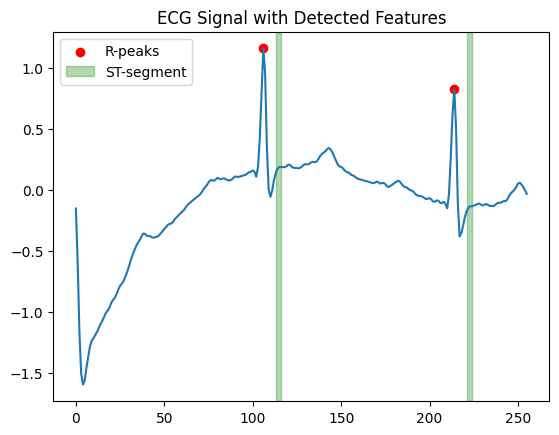

In [ ]:
plt.plot(ecg_cleaned[:256])
filtered_r_peaks = r_peaks[r_peaks < 256]
plt.scatter(filtered_r_peaks, ecg_cleaned[filtered_r_peaks], color='red', label="R-peaks")
for i, r_peak in enumerate(filtered_r_peaks):
    plt.axvspan(r_peak + st_start, r_peak + st_end, color='green', alpha=0.3, label="ST-segment" if i == 0 else None)
plt.title("ECG Signal with Detected Features")
plt.legend()
plt.show()